In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib inline

In [2]:
mean = [[0, 0], [50, 40], [-10, 40]]
cov = [[[50, 20], [30, 40]], [[400, 500], [200, 400]], [[100, 20], [60, 40]]]
ms = 3

(-54.69220620432155,
 121.06952696084592,
 -53.640803584093284,
 128.0193632792602)

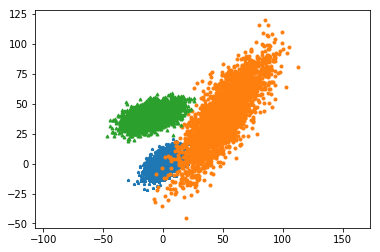

In [3]:
x0, y0 = np.random.multivariate_normal(mean[0], cov[0], 2500).T
x1, y1 = np.random.multivariate_normal(mean[1], cov[1], 3000).T
x2, y2 = np.random.multivariate_normal(mean[2], cov[2], 4500).T
plt.plot(x0, y0, '*', markersize = ms)
plt.plot(x1, y1, 'o', markersize = ms)
plt.plot(x2, y2, '^', markersize = ms)
plt.axis('equal')

In [33]:
X = np.c_[np.concatenate([x0, x1, x2]), np.concatenate([y0, y1, y2])]
Y = np.concatenate([[0 for i in xrange(len(x0))], [1 for i in xrange(len(x1))], [2 for i in xrange(len(x2))]])
num = len(X)
idx = np.arange(num)
np.random.shuffle(idx)
X = np.array([X[w] for w in idx])
Y = np.array([Y[w] for w in idx])
print X
print Y

[[ 21.27590376  -8.69240046]
 [  0.06062175  46.93662536]
 [ 59.75632796  53.32898809]
 ..., 
 [-24.11446062  33.87179477]
 [ 58.49480266  43.53874751]
 [ 46.85064025  49.9574811 ]]
[1 2 1 ..., 2 1 1]


(-54.69220620432155,
 121.06952696084592,
 -53.640803584093284,
 128.0193632792602)

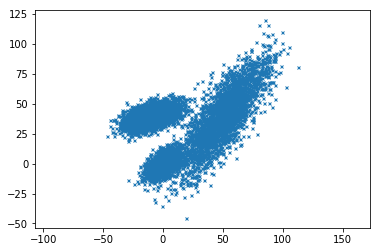

In [34]:
plt.plot(X[:,0], X[:,1], 'x', markersize = ms)
plt.axis('equal')

In [35]:
kernel = 3

In [36]:
def calc(x, m, v):
    return multivariate_normal.pdf(x, mean=m, cov=v)

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=kernel, random_state=0).fit(X)

In [38]:
label = kmeans.labels_
p = np.array([ \
    len( filter(lambda x: label[x] == k, range(num)) ) / float(num) \
    for k in xrange(kernel) ])
mu = kmeans.cluster_centers_
si = [np.array([
        [10, 0 ],
        [0 , 10]
        ]) for k in xrange(kernel)]

In [39]:
for epoch in xrange(30):
    #    E step:
    #    --
    #    pp[i][j] : P(Y_j = k | X_j, \lambda_t) = p(Y_j = k) * Gaussian(X_j, \mu[k], \Sigma[k])
    #

    pp = np.array([[   p[k] * calc( X[j], mu[k], si[k] ) for j in xrange(num)  ] for k in xrange(kernel)])
    for j in xrange(num):
        temp = np.sum(pp[:,j])
        for k in xrange(kernel):
            pp[k][j] /= temp

    #    M step:
    #    --
    #    mu[i] : \mu[k]_{t+1} = \frac{ \sum_j_{P(Y_j=k | X_j,\lambda_t) * X[j] } }^{ \sum_j_{ P(Y_j = k | X_j, \lambda_t) } }

    mu = [  np.sum([ \
                pp[k][j] * X[j]
            for j in xrange(num) ], axis=0)
          / np.sum(pp[k]) \
        for k in xrange(kernel) ]
    
    si = [ np.sum( [ \
            pp[k][j] * np.mat(X[j] - mu[k]).T * np.mat(X[j]-mu[k]) \
                for j in xrange(num) ], axis=0) \
            / np.sum(pp[k]) \
        for k in xrange(kernel) ]
    
    p  = [ np.sum(pp[k]) / float(num)  for k in xrange(kernel) ]

    print "Epoch:", epoch
    print "-" * 30
    print p
    print
    print mu[0]
    print mu[1]
    print mu[2]
    print
    print si[0]
    print si[1]
    print si[2]
    print

Epoch: 0
------------------------------
[0.45085004602906575, 0.24533988819922298, 0.30381006577171127]

[ -9.93660977  39.91163935]
[ 55.27891549  47.23164937]
[ 4.71805663  1.16903246]

[[ 114.72392362   30.58990411]
 [  30.58990411   33.49781643]]
[[ 212.1195334   190.50566014]
 [ 190.50566014  357.53295828]]
[[ 157.99204384   51.45920929]
 [  51.45920929   64.44518608]]

Epoch: 1
------------------------------
[0.4502116939751698, 0.26345098210246931, 0.286337323922361]

[ -9.97188381  39.94547491]
[ 53.48000879  44.48824774]
[ 3.1979517   0.81282926]

[[ 114.04585446   31.71309726]
 [  31.71309726   33.62132153]]
[[ 245.51393897  243.82048906]
 [ 243.82048906  445.71269622]]
[[ 124.05032213   44.93294579]
 [  44.93294579   55.01517752]]

Epoch: 2
------------------------------
[0.45010002080652828, 0.27904075507398002, 0.27085922411949176]

[ -9.97953961  39.94599684]
[ 52.06750632  42.32961906]
[ 1.76634109  0.53811338]

[[ 113.84231797   31.73915776]
 [  31.73915776   33.6281126

In [48]:
def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='r', ec=[0,0,0], a=1, lw=2):
    import numpy as np
    from scipy.stats import chi2
    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)

(-54.69220620432155,
 121.06952696084592,
 -53.640803584093284,
 128.0193632792602)

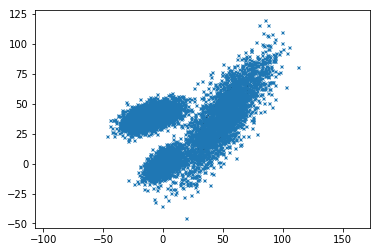

In [50]:
plt.plot(X[:,0], X[:,1], 'x', markersize = ms)
plot_cov_ellipse(si[0], mu[0])
plot_cov_ellipse(si[1], mu[1])
plot_cov_ellipse(si[2], mu[2])
plt.axis('equal')